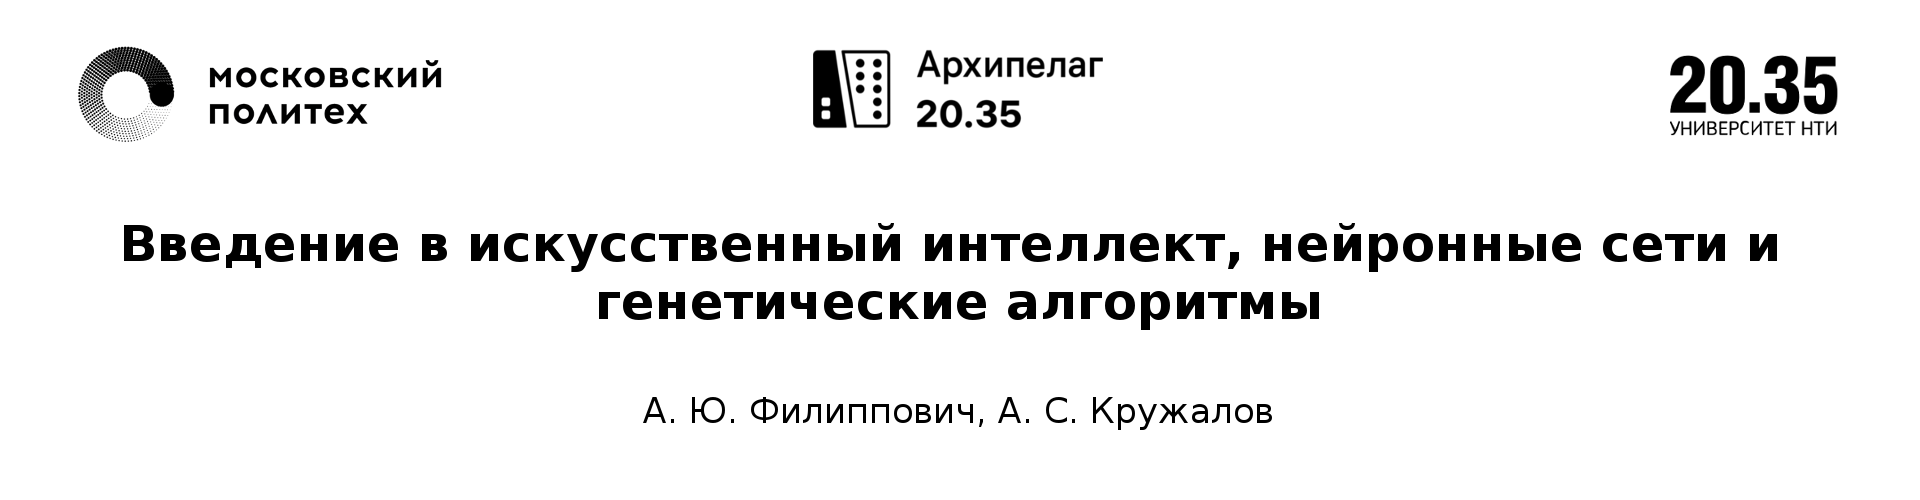

# **Решение задачи коммивояжёра с помощью генетического алгоритма**

<a href="mailto:alexkruzhalov@gmail.com">Кружалов А. С.</a> | Leader-ID: `#955144#`

**11 ноября 2020 г.**



В данной работе вам предстоит реализовать генетический алгоритм для решения задачи коммивояжёра. Вам предлагается решить конкретный экземпляр задачи коммивояжера – BERLIN52, взятый из репозитория [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html). В этой задаче необходимо найти кратчайший маршрут, соединяющий 52 точки на карте Берлина.

Ниже представлен код для загрузки файлов с исходными данными задачи. В файле `berlin52.tsp.txt` содержится список координат вершин, через которые требуется построить маршрут. В файле `berlin52.opt.tour.txt` представлена последовательность вершин, составляющих кратчайший маршрут. Его длина составляет $7544,3659$.

In [6]:
!wget http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.tsp.txt
!wget http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.opt.tour.txt

--2020-11-11 19:43:35--  http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.tsp.txt
Resolving ai.std-900.ist.mospolytech.ru (ai.std-900.ist.mospolytech.ru)... 195.9.87.69
Connecting to ai.std-900.ist.mospolytech.ru (ai.std-900.ist.mospolytech.ru)|195.9.87.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 916 [text/plain]
Saving to: ‘berlin52.tsp.txt’

berlin52.tsp.txt    100%[===================>]     916  --.-KB/s    in 0s      

2020-11-11 19:43:36 (121 MB/s) - ‘berlin52.tsp.txt’ saved [916/916]

--2020-11-11 19:43:36--  http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.opt.tour.txt
Resolving ai.std-900.ist.mospolytech.ru (ai.std-900.ist.mospolytech.ru)... 195.9.87.69
Connecting to ai.std-900.ist.mospolytech.ru (ai.std-900.ist.mospolytech.ru)|195.9.87.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219 [text/plain]
Saving to: ‘berlin52.opt.tour.txt’

berlin52.opt.tour.t 100%[===================>]     2

In [20]:
import re
import math
import numpy as np
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Ниже представлена заготовка класса генетического алгоритма. Реализуйте недостающие части.

In [49]:
class GeneticTSP:
    def __init__(self, ch_size=5, population_size=100, max_generations=1000, mutation_probability=0.5, tournament_group_size=2, \
                 selection_method='roulette', crossover_method='greedy', best_fraction=0.2, population=None, distance_matrix=None):
        # The length of chromosome
        self.ch_size = ch_size
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_probability = mutation_probability
        self.tournament_group_size = tournament_group_size
        assert selection_method in ['roulette', 'tournament']
        self.selection_method = selection_method
        assert crossover_method in ['greedy', 'permutation']
        self.crossover_method = crossover_method
        # The fraction of best individuals of current generation 
        # that will pass to the next generation unaltered (elitism). 
        self.best_fraction = best_fraction
        self.distance_matrix = distance_matrix if distance_matrix is not None else self._generate_distance_matrix()
        self.population = population or self._generate_population()
        self.best_solution = None # (Individual, fittness_func)
        
    # Generates initial population
    def _generate_population(self):
        return [Individual(size=self.ch_size, dm=self.distance_matrix) for _ in range(self.population_size)]
    
    # Generates random distance matrix 
    def _generate_distance_matrix(self):
        dm = np.random.uniform(high=100, size=(self.size, self.size))
        dm = np.tril(dm) + np.tril(dm, -1).T
        return dm
    
    # Calculates fittnes function
    # Note: fitness function must be larger for better solutions, that is why 
    # you should use the inverse value of the distance between cities as a fittness 
    # function.
    def fittnes_func(self, individual, eps=-7544.3659):
        if individual.fittness_val is None:
            dist = 0
            for i in range(self.ch_size):
                dist += self.distance_matrix[individual.chromosome[i], individual.chromosome[(i+1) % self.ch_size]]
            individual.fittness_val = 1/(dist + eps + 1)
        return individual.fittness_val

    # Implements roulette selection
    # Return value: list of individuals.
    # Hint: you can use np.random.choice function to select individuals according 
    # their selection probabilities.
    def _selection_roulette(self):
        f = np.array([self.fittnes_func(x) for x in self.population])
        probs = f/f.sum()
        return np.random.choice(self.population, p=probs, size=self.population_size).tolist()

    # Implements tournament selection
    # Return value: list of individuals.
    def _selection_tournament(self):
        selected = []
        for _ in range(self.population_size):
            winner_index = None
            winner_fit = None
            for _ in range(self.tournament_group_size):
                current_index = np.random.randint(self.population_size)
                current_fit = self.fittnes_func(self.population[current_index])
                if winner_index is None or current_fit > winner_fit:
                    winner_index = current_index
                    winner_fit = current_fit
            selected.append(self.population[winner_index])
        return selected


    # Implements selection
    def selection(self):
        if self.selection_method == 'roulette':
            return self._selection_roulette()
        elif self.selection_method == 'tournament': 
            return self._selection_tournament()

    # Generates random pair and removes it from selected list
    # Return value: tuple of two Individual class instances
    def _generate_pair(self, selected):
        parent1 = None
        parent2 = None
        tries = 0
        while parent1 is None or parent2 is None:
            parent_index = np.random.randint(len(selected))
            if parent1 is None:
                parent1 = selected.pop(parent_index)
            elif parent2 is None and (parent1 != selected[parent_index] or tries >= 10):
                parent2 = selected.pop(parent_index)
            else:
                tries += 1
        return parent1, parent2

    def _print_log(self, k, history):
        log_data = {
            'best': fitt_to_dist(history['best'][-1]),
            'mean': fitt_to_dist(history['mean'][-1]),
            'worst': fitt_to_dist(history['worst'][-1]),
            'diversity': len(set(ga.population))/len(ga.population)
        }
        template = 'Generation {generation:>10} | ' + " | ".join([f'{k} {{{k}:>10}}' for k in log_data])
        print(template.format(generation=k + 1, **log_data))
        
    
    # Runs the genetic algorithm
    def perform(self):
        history = {'best': [], 'mean': [], 'worst': []}

        for k in range(self.max_generations):
            new_population = []

            # Select individuals for crossover
            selected = self.selection()

            # Random pairing for crossover
            while len(selected) > 0:
                parent1, parent2 = self._generate_pair(selected)
                offsprings = parent1.crossover(parent2, method=self.crossover_method)
                for offspring in offsprings:
                    new_population.append(offspring.mutation(self.mutation_probability))

            # Form new population from best individuals (elitism) and offsprings
            # Hint: to sort individuals according their fitness function values 
            # you can use function `sorted` with parameter `key=self.fittnes_func`. 
            # New population must be saved in self.population attribute.

            self.population = sorted(self.population, key=self.fittnes_func, reverse=True)[:math.floor(self.best_fraction*self.population_size)]
            new_population = sorted(new_population, key=self.fittnes_func, reverse=True)
            self.population.extend(new_population[:self.population_size - len(self.population)])

            f = np.array([self.fittnes_func(x) for x in self.population])
            max_index = np.argmax(f)
            history['best'].append(f[max_index])
            history['mean'].append(f.mean())
            history['worst'].append(f.min())

            self._print_log(k, history)

            if self.best_solution is None or self.best_solution[1] < f[max_index]:
                self.best_solution = (self.population[max_index], f[max_index])

        return self.best_solution[0], history        

Ниже представлена заготовка класса особи. В этом классе должны быть реализованы операторы скрещивания и мутации. Реализуйте недостающие части.

In [77]:
class Individual:
    def __init__(self, size=None, chromosome=None, dm=None):
        assert size is not None or chromosome is not None
        self.size = size if size else len(chromosome)
        self._set_chromosome(chromosome if chromosome is not None else self._generate_chromosome())
        self.fittness_val = None
        self.dm = dm
        
    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False
        reversed_ch = np.roll(self.chromosome[::-1], 1)
        if np.all(self.chromosome == other.chromosome) or np.all(reversed_ch == other.chromosome):
            return True
        return False

    def __str__(self):
        return "_".join(map(str, self.chromosome))

    def __hash__(self):
        return hash(str(self))

    def _set_chromosome(self, chromosome):
        first_city_index = np.argmax(chromosome == 0)
        self.chromosome = np.roll(chromosome, len(chromosome) - first_city_index)
        
    # Generates random chromosome
    def _generate_chromosome(self):
        return np.random.permutation(self.size)
    
    # Implements mutation with given probability
    # Hint: you can implement it as swapping two random genes. 
    def mutation(self, prob):
        if np.random.random() < prob:
            while True:
                a = np.random.randint(self.size)
                b = np.random.randint(self.size)
                if a != b or self.size == 1:
                    break
            self.chromosome[a], self.chromosome[b] = self.chromosome[b], self.chromosome[a]
        return self

    # Generates one offspring using permutation crossover operator
    # Hint: description of permutation operator you can find here -- 
    # http://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/Order1CrossoverOperator.aspx
    def _generate_permutation_offspring(self, other):
        offspring = Individual(chromosome=np.full(self.size, -1))
        a = np.random.randint(self.size)
        b = np.random.randint(self.size)
        if a > b:
            a, b = b, a
        offspring.chromosome[a:b+1] = self.chromosome[a:b+1]
        used = set(offspring.chromosome[a:b+1])
        mask = [not other.chromosome[i] in used for i in range(self.size)]
        offspring.chromosome[offspring.chromosome == -1] = other.chromosome[mask]
        if offspring == self or offspring == other:
            offspring = offspring.mutation(1.0)
        return offspring
            

    # Generates one offspring using greedy crossover operator
    # Return value: instance of class Individual
    def _generate_greedy_offspring(self, other):
        offspring = Individual(chromosome=np.full(self.size, -1), dm=self.dm)
        offspring.chromosome[0] = np.random.randint(self.size)
        for i in range(self.size - 1):
            parent1_index = np.argmax(self.chromosome == offspring.chromosome[i])
            parent2_index = np.argmax(other.chromosome == offspring.chromosome[i])
            parent1_next_city = self.chromosome[(parent1_index + 1) % self.size]
            parent2_next_city = other.chromosome[(parent2_index + 1) % self.size]

            dist1 = self.dm[offspring.chromosome[i], parent1_next_city]
            dist2 = self.dm[offspring.chromosome[i], parent2_next_city]

            if dist1 <= dist2 and parent1_next_city not in offspring.chromosome:
                offspring.chromosome[i + 1] = parent1_next_city
            elif dist2 <= dist1 and parent2_next_city not in offspring.chromosome:
                offspring.chromosome[i + 1] = parent2_next_city
            else:
                while True:
                    random_city = np.random.randint(self.size)
                    if random_city not in offspring.chromosome:
                        offspring.chromosome[i + 1] = random_city
                        break
        return offspring


    # Implements crossover
    def crossover(self, other, method='greedy'):
        offspring_generation_method = f'_generate_{method}_offspring'
        offspring1 = getattr(self, offspring_generation_method)(other)
        offspring2 = getattr(other, offspring_generation_method)(self)
        return offspring1, offspring2

Функция `parse_tsp_file` парсит файл с координатами вершин графа и возвращает их как `numpy.array`. Функция `read_optimal` считывает оптимальный маршрут и также возвращает его в виде `numpy.array`.

In [78]:
def parse_tsp_file(filename):
    result = []
    with open(filename) as f:
        for line in f:
            m = re.match(r'(\d+) (\d+\.\d+) (\d+\.\d+)', line)
            if m:
                result.append(m.groups()[1:])
    return np.array(result, dtype=np.float32)  

In [79]:
def read_optimal(filename):
    result = []
    with open(filename) as f:
        for line in f:
            m = re.match(r'^\d+$', line.rstrip())
            if m:
                result.append(m.group())
    return np.array(result, dtype=np.int32) - 1 

In [80]:
def plot_tour(tour, nodes):
    plt.figure(dpi=150)
    plt.scatter(nodes[:, 0], nodes[:, 1])
    for i in range(len(tour)):
        x1, y1 = nodes[tour[i]]
        x2, y2 = nodes[tour[(i+1) % len(tour)]]
        if x1 > x2:
            x1, x2 = x2, x1
            y1, y2 = y2, y1
        x = np.linspace(x1, x2)
        y = (x - x1)*(y2-y1)/(x2 - x1) + y1
        plt.plot(x, y, "r--")
    plt.show()

In [81]:
# Converts fittness function value to distance value
def fitt_to_dist(f):
    return round(1/f - 1 + 7544.3659, 2)

In [82]:
nodes = parse_tsp_file('berlin52.tsp.txt')
dm = euclidean_distances(nodes)
optimal_tour = read_optimal('berlin52.opt.tour.txt')

Установите значения параметров и запустите генетический алгоритм. Попробуйте поменять значения параметров и выяснить, как это повлияет на работу генетического алгоритма.

In [88]:
params = {
    'ch_size': 52, 
    'population_size': 100, 
    'max_generations': 300, 
    'mutation_probability': 0.4, 
    'tournament_group_size': 2, 
    'selection_method': 'roulette', 
    'crossover_method': 'greedy', 
    'best_fraction': 0.2, 
    'population': None, 
    'distance_matrix': dm
}

In [89]:
ga = GeneticTSP(**params)

Длина маршрута: 30035.9600


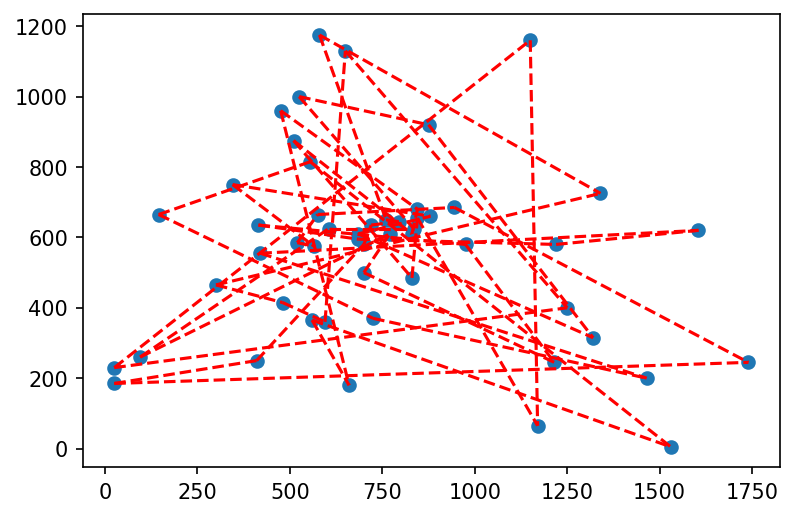

In [90]:
print("Длина маршрута: {:.4f}".format(fitt_to_dist(ga.fittnes_func(ga.population[0]))))
plot_tour(ga.population[0].chromosome, nodes)

In [91]:
solution, history = ga.perform()

Generation          1 | best   21980.09 | mean   26477.98 | worst   28595.88 | diversity        1.0
Generation          2 | best   20938.29 | mean   24224.06 | worst   26432.38 | diversity        1.0
Generation          3 | best   19746.14 | mean    22644.2 | worst   24896.83 | diversity        1.0
Generation          4 | best   17350.88 | mean   21007.68 | worst    23396.6 | diversity        1.0
Generation          5 | best    17119.4 | mean   19896.34 | worst   22660.53 | diversity        1.0
Generation          6 | best   15539.51 | mean    19404.0 | worst   22186.96 | diversity        1.0
Generation          7 | best   15385.36 | mean   19061.45 | worst   22072.33 | diversity        1.0
Generation          8 | best   15385.36 | mean   18560.21 | worst    21403.7 | diversity        1.0
Generation          9 | best   15385.36 | mean   18437.92 | worst    21311.6 | diversity        1.0
Generation         10 | best   14622.44 | mean   18015.96 | worst   20612.56 | diversity        1.0


Постройте график, показывающий, как менялись значения функции приспособленности наилучшей особи, наихудщей особи, а также в среднем по популяции в процессе работы генетического алгоритма.

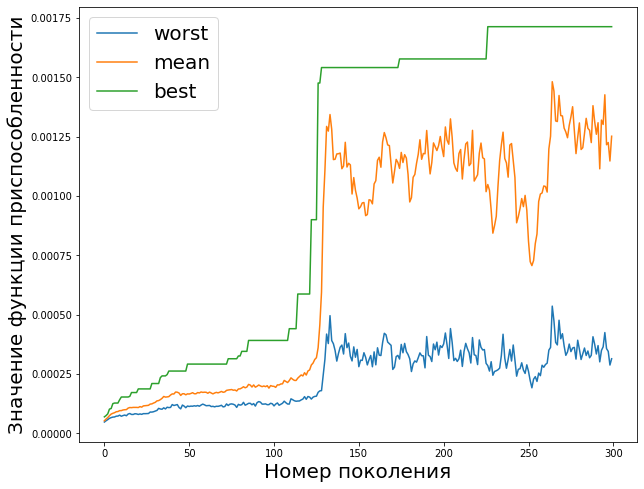

In [92]:
plt.figure(figsize=(10, 8))
plt.plot(history['worst'])
plt.plot(history['mean'])
plt.plot(history['best'])
plt.legend(['worst', 'mean', 'best'], fontsize=20)
plt.xlabel('Номер поколения', fontsize=20)
plt.ylabel('Значение функции приспособленности', fontsize=20)
plt.show()

Постройте графики, показывающие оптимальный маршрут и маршрут, найденный генетическим алгоритмом. Сравните полученные результаты.

Длина маршрута: 7544.3700


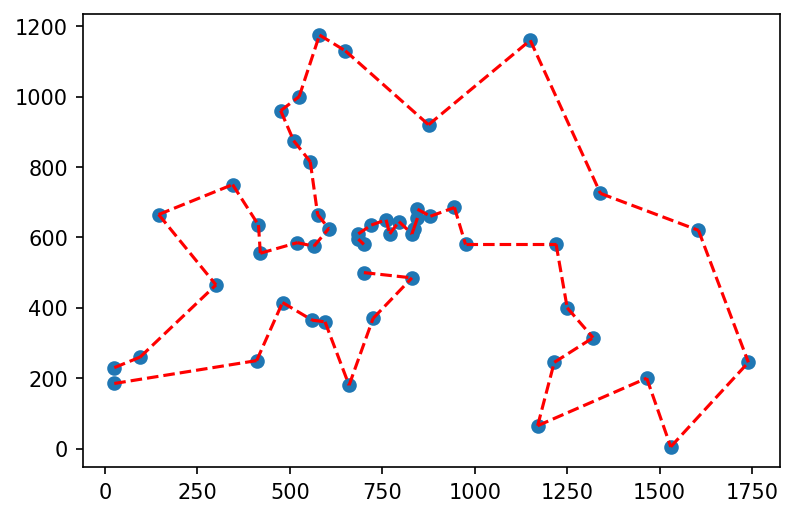

In [93]:
print("Длина маршрута: {:.4f}".format(fitt_to_dist(ga.fittnes_func(Individual(chromosome=optimal_tour)))))
plot_tour(optimal_tour, nodes)

Длина маршрута: 8127.0100


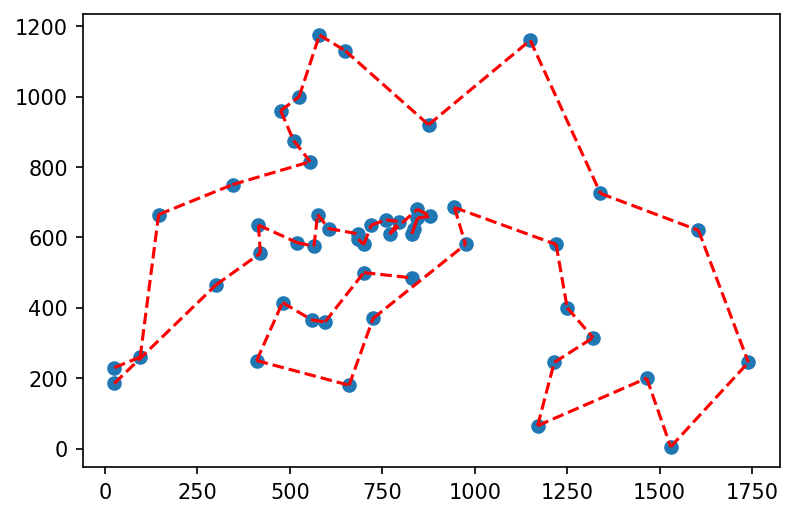

In [94]:
print("Длина маршрута: {:.4f}".format(fitt_to_dist(ga.fittnes_func(solution))))
plot_tour(solution.chromosome, nodes)